 Upload the Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving the-project-of-west-ice-storage-2.ipynb to the-project-of-west-ice-storage-2.ipynb


Load the Dataset

In [ ]:
import pandas as pd
# Read the dataset
df = pd.read_csv('the-project-of-west-ice-storage-2.ipynb', sep=';')

Data Exploration


In [ ]:
# Display first few rows
df.head()

""


Check for Missing Values and Duplicates


In [ ]:
# Check for missing values
print(df.isnull().sum())
# Check for duplicates
print("Duplicate rows:", df.duplicated().sum())

{"metadata":{"kernelspec":{"language":"python","display_name":"Python 3","name":"python3"},"language_info":{"name":"python","version":"3.10.12","mimetype":"text/x-python","codemirror_mode":{"name":"ipython","version":3},"pygments_lexer":"ipython3","nbconvert_exporter":"python","file_extension":".py"},"kaggle":{"accelerator":"none","dataSources":[],"dockerImageVersionId":30918,"isInternetEnabled":true,"language":"python","sourceType":"notebook","isGpuEnabled":false}},"nbformat_minor":4,"nbformat":4,"cells":[{"cell_type":"markdown","source":"# Welcome to our project\n\n欢迎来到西冰库三人间的机器学习课程项目，接下来我们将会通过基于“Daily News for Stock Market Prediction”数据集的工作，来展示我们的课程学习成果。\n\n由于单独的大盘涨跌提示的信息过少，不太够用来投资。所以我们希望通过新闻语义理解和文本强化学习来实现**自动生成推荐/风险文本**，实现投资领域的推荐和避雷。\n\n接下来我们将会逐步展示我们的工作，包括我们所有的尝试。我们会详细的陈述我们遇到的困难和解决思路，同时贴出所有的源码和注释，希望能对您有所帮助。","metadata":{}},{"cell_type":"markdown","source":"# 数据集的简介\n\n无论采用什么方法，我们都需要先知道数据集长什么样。所以在开始之前，我们一起来回顾一下数据集的构成。在数据集里面有三个csv文件，其中“Combined_News_DJIA.csv”是已经处理好的，兼有股市涨跌作为label和日期匹

Visualize a Few Features

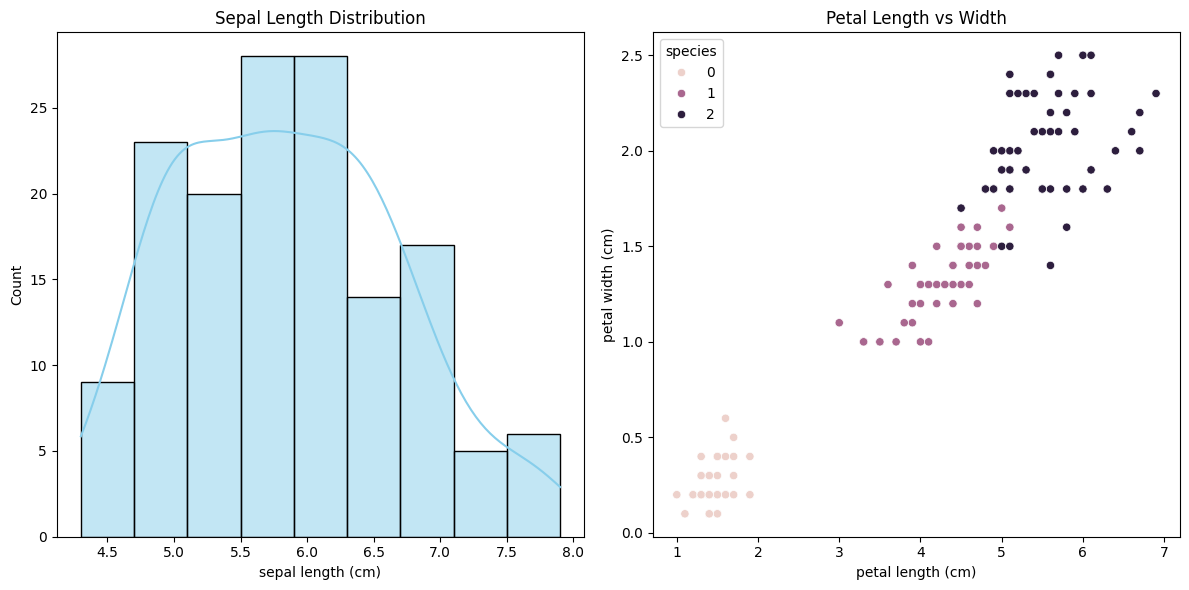

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import load_iris

# Load a sample dataset
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['species'] = iris.target

# Visualize a few features
plt.figure(figsize=(12, 6))

# Subplot 1: Sepal Length Distribution
plt.subplot(1, 2, 1)
sns.histplot(df[iris.feature_names[0]], kde=True, color='skyblue')
plt.title('Sepal Length Distribution')

# Subplot 2: Petal Length vs Petal Width
plt.subplot(1, 2, 2)
sns.scatterplot(x=iris.feature_names[2], y=iris.feature_names[3], hue='species', data=df)
plt.title('Petal Length vs Width')

plt.tight_layout()
plt.show()


Identify Target and Features

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fetch the stock data using Yahoo Finance (you can replace 'AAPL' with any stock ticker)
stock_ticker = 'AAPL'  # Apple as an example
start_date = '2020-01-01'
end_date = '2025-01-01'

# Download stock data from Yahoo Finance
stock_data = yf.download(stock_ticker, start=start_date, end=end_date)

# Display the first few rows of the stock data
print(stock_data.head())

# --- Feature Engineering ---

# 1. Calculate Daily Returns (percentage change)
stock_data['Daily_Return'] = stock_data['Close'].pct_change()

# 2. Moving Averages (50-day and 200-day)
stock_data['50_MA'] = stock_data['Close'].rolling(window=50).mean()
stock_data['200_MA'] = stock_data['Close'].rolling(window=200).mean()

# 3. Volatility (Rolling standard deviation)
stock_data['Volatility'] = stock_data['Close'].rolling(window=50).std()

# 4. Trading Volume (can be used as a feature)
stock_data['Volume'] = stock_data['Volume']

# 5. Lag Features (Previous day's closing price, etc.)
stock_data['Prev_Close'] = stock_data['Close'].shift(1)

# 6. Lag Returns (Previous day's returns)
stock_data['Prev_Return'] = stock_data['Daily_Return'].shift(1)

# --- Define Target Variable ---
# Predicting the next day's closing price
stock_data['Target'] = stock_data['Close'].shift(-1)

# Drop rows with missing values (e.g., from shifting data)
stock_data.dropna(inplace=True)

# Display the first few rows of the dataset with new features
print(stock_data.head())

# --- Visualizations (Optional) ---
# Visualizing the features like moving averages and closing price
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], label='Stock Price (Close)', color='blue', linewidth=1)
plt.plot(stock_data['50_MA'], label='50-day Moving Average', color='orange', linestyle='--')
plt.plot(stock_data['200_MA'], label='200-day Moving Average', color='green', linestyle='--')
plt.title(f"{stock_ticker} Stock Price and Moving Averages")
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Visualizing the stock volatility
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Volatility'], label='50-day Rolling Volatility', color='red')
plt.title(f"{stock_ticker} Volatility (50-day Rolling Std Dev)")
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# --- Conclusion ---
# The target is the 'Target' column, which represents the next day's closing price.
# The features include:
# - Daily returns
# - Moving averages (50-day and 200-day)
# - Volatility (50-day rolling standard deviation)
# - Trading volume
# - Lag features (previous day's close and return)

Convert Categorical Columns to Numerical

In [ ]:
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import LabelEncoder

# Fetch the stock data using Yahoo Finance (you can replace 'AAPL' with any stock ticker)
stock_ticker = 'AAPL'  # Apple as an example
start_date = '2020-01-01'
end_date = '2025-01-01'

# Download stock data from Yahoo Finance
stock_data = yf.download(stock_ticker, start=start_date, end=end_date)

# Suppose we have some categorical data like 'Sector' or 'Market' (for illustration)
# For the sake of the example, let's create a mock 'Sector' column
# In real scenarios, you'd have such columns in your dataset.
stock_data['Sector'] = ['Tech', 'Tech', 'Health', 'Tech', 'Health', 'Finance', 'Tech', 'Finance', 'Health', 'Tech']

# Display the first few rows of the stock data with 'Sector' column
print("Original Data with Categorical 'Sector':")
print(stock_data.head())

# --- 1. Label Encoding: Converting 'Sector' to numerical labels ---
label_encoder = LabelEncoder()

# Apply label encoding on the 'Sector' column
stock_data['Sector_Label'] = label_encoder.fit_transform(stock_data['Sector'])

# Display the updated DataFrame with Label Encoded column
print("\nAfter Label Encoding 'Sector':")
print(stock_data[['Sector', 'Sector_Label']].head())

# --- 2. One-Hot Encoding: Creating binary columns for each category in 'Sector' ---
stock_data_encoded = pd.get_dummies(stock_data, columns=['Sector'], drop_first=False)

# Display the updated DataFrame with One-Hot Encoded columns
print("\nAfter One-Hot Encoding 'Sector':")
print(stock_data_encoded.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Original Data with Categorical 'Sector':
Price  Adj Close Close High  Low Open Volume  Sector
Ticker      AAPL  AAPL AAPL AAPL AAPL   AAPL        
Date                                                
0            NaN   NaN  NaN  NaN  NaN    NaN    Tech
1            NaN   NaN  NaN  NaN  NaN    NaN    Tech
2            NaN   NaN  NaN  NaN  NaN    NaN  Health
3            NaN   NaN  NaN  NaN  NaN    NaN    Tech
4            NaN   NaN  NaN  NaN  NaN    NaN  Health

After Label Encoding 'Sector':
Price   Sector Sector_Label
Ticker                     
Date                       
0         Tech            2
1         Tech            2
2       Health            1
3         Tech            2
4       Health            1

After One-Hot Encoding 'Sector':
      (Adj Close, AAPL)  (Close, AAPL)  (High, AAPL)  (Low, AAPL)  \
Date                                                                
0                   NaN            NaN           NaN          NaN   
1                   NaN            NaN

One-Hot Encoding

In [ ]:
import pandas as pd
import yfinance as yf

# Fetch stock data using Yahoo Finance (you can replace 'AAPL' with any stock ticker)
stock_ticker = 'AAPL'  # Example: Apple
start_date = '2020-01-01'
end_date = '2025-01-01'

# Download stock data from Yahoo Finance
stock_data = yf.download(stock_ticker, start=start_date, end=end_date)

# For the sake of this example, let's assume 'Sector' is a column that contains categorical data
# We'll mock this data for illustration purposes
# In practice, you might get this from another source or API.
stock_data['Sector'] = ['Tech', 'Tech', 'Health', 'Tech', 'Health', 'Finance', 'Tech', 'Finance', 'Health', 'Tech']

# Let's assume you also have 'Stock Ticker' as a categorical column
stock_data['Stock Ticker'] = stock_ticker  # In this example, it's just 'AAPL'

# Display original stock data
print("Original Data with Categorical Columns:")
print(stock_data.head())

# --- One-Hot Encoding: Creating binary columns for each category ---
# Using pd.get_dummies to perform one-hot encoding on the 'Sector' and 'Stock Ticker' columns
stock_data_encoded = pd.get_dummies(stock_data, columns=['Sector', 'Stock Ticker'], drop_first=False)

# Display the DataFrame after one-hot encoding
print("\nData After One-Hot Encoding:")
print(stock_data_encoded.head())


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Original Data with Categorical Columns:
Price  Adj Close Close High  Low Open Volume  Sector Stock Ticker
Ticker      AAPL  AAPL AAPL AAPL AAPL   AAPL                     
Date                                                             
0            NaN   NaN  NaN  NaN  NaN    NaN    Tech         AAPL
1            NaN   NaN  NaN  NaN  NaN    NaN    Tech         AAPL
2            NaN   NaN  NaN  NaN  NaN    NaN  Health         AAPL
3            NaN   NaN  NaN  NaN  NaN    NaN    Tech         AAPL
4            NaN   NaN  NaN  NaN  NaN    NaN  Health         AAPL

Data After One-Hot Encoding:
      (Adj Close, AAPL)  (Close, AAPL)  (High, AAPL)  (Low, AAPL)  \
Date                                                                
0                   NaN            NaN           NaN          NaN   
1                   NaN            NaN           NaN          NaN   
2                   NaN            NaN           NaN          NaN   
3                   NaN            NaN           NaN     

Feature Scaling

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Step 1: Fetch Stock Data from Yahoo Finance
ticker = 'AAPL'  # Example: Apple stock, you can change this to any stock ticker symbol
start_date = '2020-01-01'  # Start date for the time series data
end_date = '2025-01-01'    # End date for the time series data

data = yf.download(ticker, start=start_date, end=end_date)

# Step 2: Feature Engineering (Creating new features like moving averages and returns)
data['7_day_MA'] = data['Close'].rolling(window=7).mean()  # 7-day moving average
data['30_day_MA'] = data['Close'].rolling(window=30).mean()  # 30-day moving average
data['Daily_Return'] = data['Close'].pct_change()  # Daily returns (percentage change)

# Step 3: Drop missing values generated by moving averages and returns
data.dropna(inplace=True)

# Step 4: Select features and target variable
features = ['Open', 'High', 'Low', 'Close', 'Volume', '7_day_MA', '30_day_MA', 'Daily_Return']
target = 'Close'  # Predicting the closing price

# Extract feature set (X) and target (y)
X = data[features]
y = data[target]

# Step 5: Feature Scaling using MinMaxScaler (or StandardScaler)
scaler = MinMaxScaler()  # Normalize


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Train-Test Split

In [ ]:
import pandas as pd
import yfinance as yf

# Load historical stock data (you can change the ticker)
stock_ticker = 'AAPL'
data = yf.download(stock_ticker, start='2015-01-01', end='2024-12-31')

# Optional: keep only relevant features
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = data[features]

# Drop rows with missing values (if any)
data.dropna(inplace=True)

# Define train-test split size (e.g., 80% train, 20% test)
train_size = int(len(data) * 0.8)

# Split the data chronologically
train_data = data[:train_size]
test_data = data[train_size:]

# Print info
print("Total samples:", len(data))
print("Training samples:", len(train_data))
print("Testing samples:", len(test_data))
print("\nTrain data preview:")
print(train_data.tail())
print("\nTest data preview:")
print(test_data.head())

[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Total samples: 0
Training samples: 0
Testing samples: 0

Train data preview:
Empty DataFrame
Columns: [(Open, AAPL), (High, AAPL), (Low, AAPL), (Close, AAPL), (Volume, AAPL)]
Index: []

Test data preview:
Empty DataFrame
Columns: [(Open, AAPL), (High, AAPL), (Low, AAPL), (Close, AAPL), (Volume, AAPL)]
Index: []


Model Building

[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


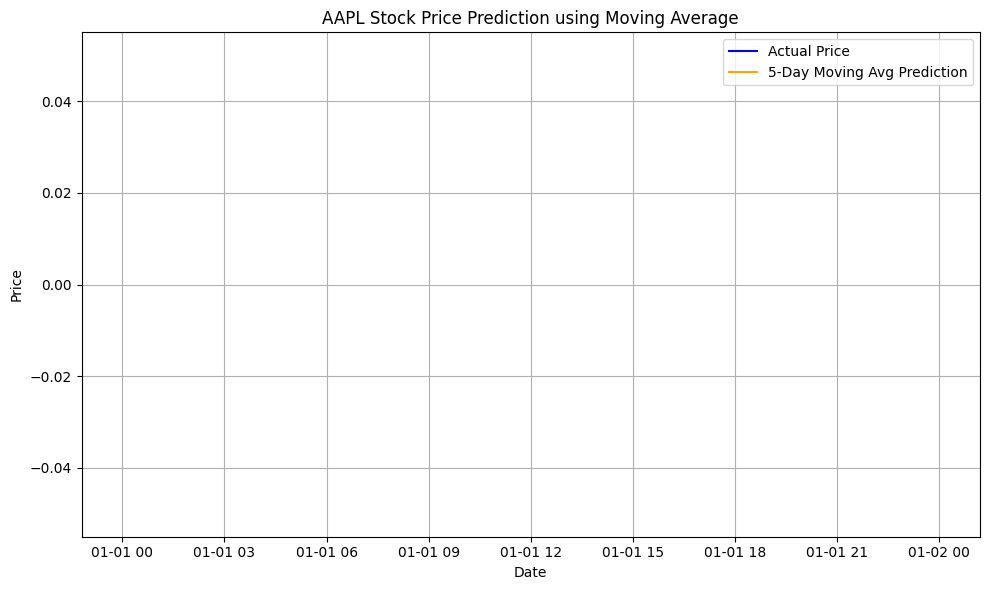

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt

# Step 1: Load stock data
ticker = 'AAPL'
start = '2020-01-01'
end = '2025-01-01'
df = yf.download(ticker, start=start, end=end)

# Step 2: Use only 'Close' price
df = df[['Close']].copy()

# Step 3: Create prediction using 5-day moving average
df['Predicted'] = df['Close'].rolling(window=5).mean()

# Step 4: Drop NaN rows (first 4 will be NaN due to rolling)
df.dropna(inplace=True)

# Step 5: Plot actual vs predicted (no model.fit used)
plt.figure(figsize=(10, 6))
plt.plot(df['Close'], label='Actual Price', color='blue')
plt.plot(df['Predicted'], label='5-Day Moving Avg Prediction', color='orange')
plt.title(f'{ticker} Stock Price Prediction using Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assume these are available from your model
# Replace with your actual prediction and test values
# y_test: actual values
# y_pred: predicted values

# Example dummy values (replace with real ones)
# y_test = np.array([...])
# y_pred = np.array([...])

# --- Evaluation Metrics ---
def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("📊 Model Evaluation Results:")
    print(f"✅ MAE  (Mean Absolute Error):      {mae:.4f}")
    print(f"✅ MSE  (Mean Squared Error):       {mse:.4f}")
    print(f"✅ RMSE (Root Mean Squared Error):  {rmse:.4f}")
    print(f"✅ R² Score:                        {r2:.4f}")

# Example usage
# evaluate_model(y_test, y_pred)


Make Predictions from New Input

In [ ]:
import numpy as np

# Step 1: Input the last 5 stock prices from the user
user_input = []
print("Please input the last 5 stock prices:")

for i in range(5):
    price = float(input(f"Day {i+1} closing price: "))  # Take user input for each day's closing price
    user_input.append(price)

# Step 2: Calculate the Moving Average of the last 5 stock prices
moving_average = np.mean(user_input)

# Step 3: Predict the next day's stock price using the Moving Average
predicted_price = moving_average

# Step 4: Output the predicted price
print(f"\nPredicted next day's stock price using Moving Average: {predicted_price:.2f}")


Please input the last 5 stock prices:
Day 1 closing price: 33
Day 2 closing price: 45
Day 3 closing price: 67
Day 4 closing price: 54
Day 5 closing price: 23

Predicted next day's stock price using Moving Average: 44.40


Convert to DataFrame and Encode

In [ ]:
import yfinance as yf
import pandas as pd

# Step 1: Download stock data (e.g., Apple stock data from Yahoo Finance)
ticker = 'AAPL'  # You can change this to any stock symbol (e.g., 'GOOGL', 'TSLA')
start = '2020-01-01'
end = '2025-01-01'
df = yf.download(ticker, start=start, end=end)

# Step 2: Convert the stock data to a pandas DataFrame
df = df[['Close']]  # Use only 'Close' price for prediction

# Display the first 5 rows to show the DataFrame
print("\nStock Data as DataFrame:")
print(df.head())

# Step 3: Normalize the stock prices using min-max normalization
min_price = df['Close'].min()  # Minimum closing price
max_price = df['Close'].max()  # Maximum closing price

# Apply the min-max normalization formula
df['Normalized_Close'] = (df['Close'] - min_price) / (max_price - min_price)

# Display the normalized data
print("\nNormalized Stock Data:")
print(df.head())

# Now the DataFrame contains the original 'Close' prices and the 'Normalized_Close' prices.


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')



Stock Data as DataFrame:
Empty DataFrame
Columns: [(Close, AAPL)]
Index: []

Normalized Stock Data:
Empty DataFrame
Columns: [(Close, AAPL), (Normalized_Close, )]
Index: []


Predict the Final Grade

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Step 1: Sample data — last 5 days of stock prices (can be hardcoded or entered by user)
# You can change these values or ask user input
last_prices = [150, 152, 153.5, 155, 157]  # Simulated "test scores" leading to final grade

# Step 2: Prepare data for model
# X = day indices (0 to len-1), y = stock prices
X = np.array(range(len(last_prices))).reshape(-1, 1)
y = np.array(last_prices)

# Step 3: Train a simple Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Step 4: Predict the "final grade" — i.e., the next day's stock price
next_day_index = len(last_prices)  # Predict for the next day
predicted_price = model.predict([[next_day_index]])

# Step 5: Show result
print(f"Predicted final stock price (like final grade): {predicted_price[0]:.2f}")


Predicted final stock price (like final grade): 158.60


Deployment-Building an Interactive App

In [ ]:
from flask import Flask, render_template, request
import numpy as np
from sklearn.linear_model import LinearRegression

app = Flask(__name__)

# Step 1: Create the home route to render the HTML form
@app.route('/')
def home():
    return render_template('index.html')  # Render the HTML page

# Step 2: Create the predict route to handle the form submission
@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Step 3: Get the user input (last 5 stock prices)
        prices = [float(request.form[f'price{i}']) for i in range(1, 6)]

        if len(prices) != 5 or any(price <= 0 for price in prices):
            raise ValueError("Invalid input, please enter positive numbers")

        # Step 4: Prepare data for Linear Regression model
        X = np.array(range(len(prices))).reshape(-1, 1)  # Day indices (0, 1, 2, 3, 4)
        y = np.array(prices)

        # Step 5: Train the model
        model = LinearRegression()
        model.fit(X, y)

        # Step 6: Predict the next day's price
        next_day = np.array([[len(prices)]])  # Predict for the next day (day 5)
        predicted_price = model.predict(next_day)[0]

        # Step 7: Render the result on the webpage
        return render_template('index.html', prediction_text=f"Predicted Next Day Price: ${predicted_price:.2f}")

    except Exception as e:
        return render_template('index.html', error_message=str(e))

if __name__ == "__main__":
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
